In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import lightgbm as lgb
from sklearn.metrics import (roc_curve, auc, accuracy_score, roc_auc_score)
import seaborn as sns
import matplotlib.pyplot as plt
import shap

Define the supposedly numerical columns:

In [2]:
nums = ['Census_ProcessorCoreCount',
        'Census_PrimaryDiskTotalCapacity',
        'Census_SystemVolumeTotalCapacity',
        'Census_TotalPhysicalRAM',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches',
        'Census_InternalPrimaryDisplayResolutionHorizontal',
        'Census_InternalPrimaryDisplayResolutionVertical',
        'Census_InternalBatteryNumberOfCharges']

## apparently these might be the true numericals
#nums_2 = [  # All the columns which have a real continuous data
#    'Census_ProcessorCoreCount',
#    'Census_PrimaryDiskTotalCapacity',
#    'Census_SystemVolumeTotalCapacity',
#    'Census_TotalPhysicalRAM',
#    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
#    'Census_InternalPrimaryDisplayResolutionHorizontal',
#   'Census_InternalPrimaryDisplayResolutionVertical',
#    'Census_InternalBatteryNumberOfCharges',
#    'Census_OSBuildNumber',
#    'Census_OSBuildRevision',
#    'Census_ThresholdOptIn',
#    'OsBuild'
#]

Load the dataset with integer-encoded categorical variables to run through the LGBM classifier

In [3]:
# LOAD INTEGER ENCODED TRAININIG DATA 

with open('LGBM_train.pickle', 'rb') as handle:
    malware_train = pickle.load(handle)
    
cat_cols = [col for col in malware_train.columns if col not in nums and col != 'HasDetections']
#cat_cols_2 = [col for col in malware_train.columns if col not in nums_2 and col != 'HasDetections']

targets = malware_train["HasDetections"]
malware_train.drop(["HasDetections"], axis = 1, inplace = True)

Define the dictionary with the hyperparameters for the LGBM classifier obtained through Randomized Grid Search with 50 repetitions. In each iteration, cross-validation was performed through 10 splits of the original dataset into training and validation subsets containing 5% and 0.5% of the original dataset respectively (the original dataset had almost 9 million observations).

In [4]:
int_enc_params = {
    'subsample': 1.0, 
    'reg_alpha': 100,
    'num_leaves': 90,
    'n_estimators': 200,
    'min_child_samples': 1700, 
    'learning_rate': 0.1, 
    'colsample_bytree': 0.9,
    'boosting_type': 'gbdt',
    'objective' : 'binary',
    'n_jobs' : -1
}

### Don't know if the dictionary below is correct - commented out just in case
#clean_params = {
#    'objective': 'binary',
#    'subsample': 0.9,
#     'reg_alpha': 5, 
#     'num_leaves': 110, 
#     'n_estimators': 200, 
#     'min_child_samples': 900,
#     'learning_rate': 0.1,
#     'colsample_bytree': 0.4, 
#     'boosting_type': 'gbdt'}

Create an LGBM Classifier instance and set the best hyperparameters determined by RGS

In [5]:
int_enc_lgbm = lgb.LGBMClassifier()
int_enc_lgbm.set_params(**int_enc_params)
#radom_lgbm.set_params(**{"early_stopping_rounds": None})

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=1700, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=90,
               objective='binary', random_state=None, reg_alpha=100,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

Train the model with 15% of the data used as hold-out set

In [6]:
x_train, x_val, y_train, y_val = train_test_split(malware_train, targets, 
                                                test_size=0.15, stratify=targets,
                                                  random_state = 42)

In [ ]:
int_enc_lgbm.fit(x_train, y_train,
                early_stopping_rounds = 100,
                eval_set=[(x_val, y_val)],
                feature_name = x_train.columns.to_list(),
                categorical_feature = cat_cols,
                eval_metric = 'auc', 
                verbose = 0)

with open('supposedly_best_lgbm.pickle', 'wb') as handle:
    pickle.dump(int_enc_lgbm, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
######## SUBMISSION ##########

# LOAD INTEGER-ENCODED TEST DATA
with open('LGBM_test.pickle', 'rb') as handle:
    test = pickle.load(handle)
    
features = [col for col in test.columns if col != "MachineIdentifier"]
probs = full_data_best_lgbm.predict_proba(test[features])

sub_df = pd.read_csv("sample_submission.csv")
sub_df['HasDetections'] = probs[:, 1]
sub_df.to_csv('lgbm_submission.csv', index=False)

The private score achieved with the above method was 0.60672 (as a comment on that value, the winner's score was 0.67585, and also when the submission was made incorrectly, ie. instead of probabilities the predicted classes have been included in the submission file, the score was 0.55759...). Clearly, there is room for improvement. We will try to see what information we can extract from the model:

In [4]:
with open('supposedly_best_lgbm.pickle', 'rb') as handle:
    full_data_best_lgbm = pickle.load(handle)

Check the model performance on the hold-out set:

In [18]:
preds = full_data_best_lgbm.predict_proba(x_val)
roc_auc_score(y_val, preds[:,1])

0.7361017651348088

Try to see which features were deemed most influential in our model:

In [19]:
feat_imp = pd.DataFrame({"Feature": malware_train.columns.to_list(),
                         "Importance": full_data_best_lgbm.feature_importances_})

Boolean Series key will be reindexed to match DataFrame index.


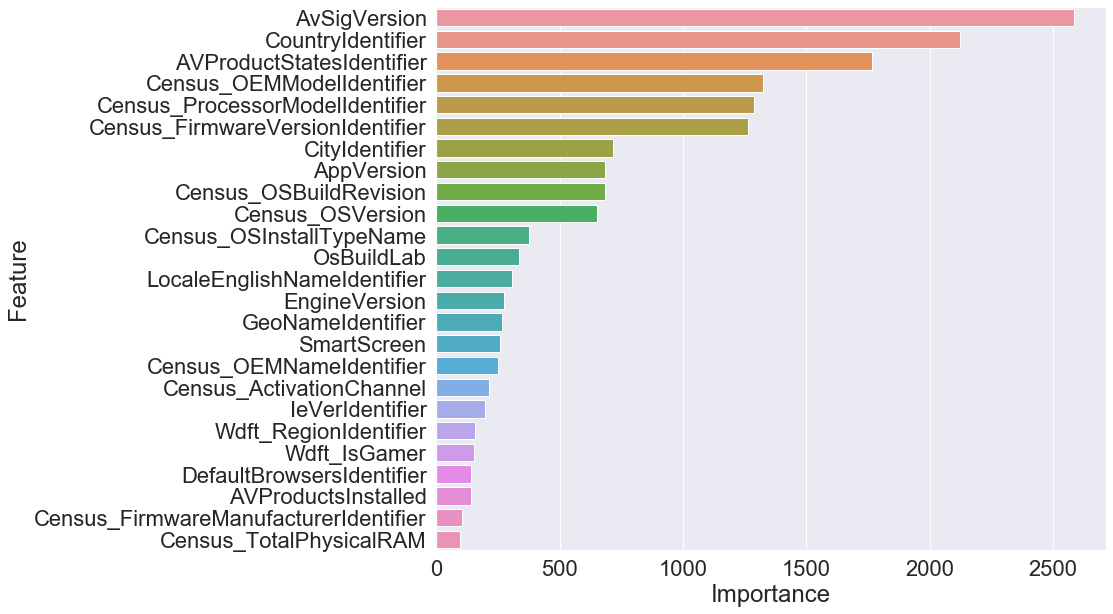

In [21]:
plt.figure(figsize = (12, 10))
sns.set(font_scale=2)
sns.barplot(y = 'Feature', x = 'Importance',
            data = feat_imp.sort_values(by = 'Importance', ascending = False)[feat_imp['Importance'] > 20].head(25))

- Out of the top 3 most important features, two of them are Anti-Virus related, which intuitively makes sense. 
- Also, it seems that the country of the machine's origin matters, suggesting that people in certain countries may be more frequent targets (or just victims) of malware attacks.
- Interestingly, according to our LGBM model, the number of Anti-Virus software on one machine (`AVProductsInstalled`) turns out not as important as one might think...
- 

Additionally, we can see that a couple of features were deemed absolutely useless (Importance = 0):

In [22]:
sum(feat_imp['Importance'] == 0)

9

In [23]:
feat_imp[feat_imp['Importance'] == 0]['Feature']

0                          ProductName
4                               IsBeta
17                            Platform
19                               OsVer
26                     AutoSampleOptIn
34                 Census_DeviceFamily
63    Census_IsPortableOperatingSystem
67            Census_IsFlightsDisabled
74              Census_IsVirtualDevice
Name: Feature, dtype: object

In [24]:
best_lgbm_shap = full_data_best_lgbm.predict(malware_train, pred_contrib=True)

MemoryError: Unable to allocate 5.38 GiB for an array with shape (722640123,) and data type float64

In [ ]:
explainer = shap.TreeExplainer(full_data_best_lgbm)
shap_values = explainer.shap_values(malware_train)

In [ ]:
shap.summary_plot(shap_values, malware_train)

We will now try to create another model, this time using the top features determined through the conditional mutual information ranking.

In [12]:
# TOP 28 FEATURES ACCORDING TO CMI

CI_feature_rank = [
 'Census_SystemVolumeTotalCapacity',
 'Census_PowerPlatformRoleName',
 'Census_ChassisTypeName',
 'Census_InternalBatteryType',
 'SmartScreen',
 'AVProductsInstalled',
 'Processor',
 'RtpStateBitfield',
 'OsBuildLab',
 'AVProductsEnabled',
 'Census_MDC2FormFactor',
 'PuaMode',
 'Census_ProcessorClass',
 'UacLuaenable',
 'Census_DeviceFamily',
 'ProductName',
 'Platform',
 'Census_FlightRing',
 'Census_GenuineStateName',
 'Census_ProcessorManufacturerIdentifier',
 'Census_OSWUAutoUpdateOptionsName',
 'OsPlatformSubRelease',
 'Census_OSSkuName',
 'Census_OSEdition',
 'SkuEdition',
 'Census_ActivationChannel',
 'Census_OSBranch',
 'Census_PrimaryDiskTypeName'
]

The hyperparameters for the model have been obtained again through a Randomed Grid Search on the reduced dataset with 100 iterations. In each iteration, cross-validation was performed through 10 splits of the original dataset into training and validation subsets containing 10% and 1% of the original dataset respectively.

Exemp from one of the top scoring notebooks: 

> *The private dataset contains 33% outliers. Those outliers ruin every model's score. This is explained here. When those outliers are removed, this model scores an amazing 0.775 AUC !!*